In [1]:
import pandas as pd #the csv reading library
import matplotlib.pyplot as plt #the ploting library
import glob #to get file names
import scipy.optimize
from scipy.optimize import curve_fit
from scipy import interpolate
from scipy.interpolate import pchip_interpolate
import numpy as np
import math
from pandas import Series
from lmfit import Model, Parameter, report_fit
import scipy.ndimage
from scipy.ndimage import gaussian_filter1d
from scipy.signal import savgol_filter
from numpy import ones,vstack
from numpy.linalg import lstsq

In [2]:
files = glob.glob('../../../Data_Thesis/Iron/WC_FeT_Rerun/Iron_2219_20_21_22_23/*.txt')
files_nm = glob.glob('../../../Data_Thesis/Iron/WC_FeT_Rerun/Iron_2219_20_21_22_23/*nm*.txt')

#here is where the output will go 
path_save_1 = '../../../Data_Thesis/Iron/WC_FeT_Rerun/Cruve_Iron_2219_20_21_22_23.csv'
path_save_2 = '../../../Data_Thesis/Iron/WC_FeT_Rerun/Iron_2219_20_21_22_23.csv'
files

['../../../Data_Thesis/Iron/WC_FeT_Rerun/Iron_2219_20_21_22_23\\000_nm_post_Absorbance_09-17-52-531 (2).txt',
 '../../../Data_Thesis/Iron/WC_FeT_Rerun/Iron_2219_20_21_22_23\\000_nm_post_Absorbance_09-17-52-531.txt',
 '../../../Data_Thesis/Iron/WC_FeT_Rerun/Iron_2219_20_21_22_23\\000_nm_pre_Absorbance_08-07-43-223 (2).txt',
 '../../../Data_Thesis/Iron/WC_FeT_Rerun/Iron_2219_20_21_22_23\\000_nm_pre_Absorbance_08-07-43-223.txt',
 '../../../Data_Thesis/Iron/WC_FeT_Rerun/Iron_2219_20_21_22_23\\010_nm_post_Absorbance_09-19-53-726 (2).txt',
 '../../../Data_Thesis/Iron/WC_FeT_Rerun/Iron_2219_20_21_22_23\\010_nm_post_Absorbance_09-19-53-726.txt',
 '../../../Data_Thesis/Iron/WC_FeT_Rerun/Iron_2219_20_21_22_23\\010_nm_post_Absorbance_09-19-54-637 (2).txt',
 '../../../Data_Thesis/Iron/WC_FeT_Rerun/Iron_2219_20_21_22_23\\010_nm_post_Absorbance_09-19-54-637.txt',
 '../../../Data_Thesis/Iron/WC_FeT_Rerun/Iron_2219_20_21_22_23\\010_nm_post_Absorbance_09-19-58-283 (2).txt',
 '../../../Data_Thesis/Iron/

In [3]:
def GET_DATA(name):
    df = pd.read_csv(name, skiprows=15, sep='\t', names=['wl', 'abs'], )
    df['abs'] = df['abs']
    #df['wl'] = df['wl']
    #bcorr = df[(df['wl']>=700) & (df['wl']<=701)]['abs'].mean() # a float corection with just 700 nm 
    bcorr = df[(df['wl']>=700) & (df['wl']<=750)]['abs'].mean() # a float corection with 700 to 750 nm 
    df['abs'] = df['abs'] - bcorr
    x = df['wl']
    y = df['abs'] 
    pchip_obj1 = scipy.interpolate.PchipInterpolator(x, y, axis=0, extrapolate=None)
    xi = np.arange(189,881,1)
    yi = pchip_obj1(xi)
    d = {'wl': xi, 'abs': yi}
    df = pd.DataFrame(d)
    return df

In [4]:
frames = []
for f in files:
    df = GET_DATA(f) # runs the processing function 
    ID = f.split("\\")[1] #takes junk out of the file name to make a single ID 
    df = df.rename(columns={'abs': ID}) # renames the abs col to the new id 
    df = df.set_index('wl', drop=True) # makes the wl the new index, aka the rows 
    frames.append(df) # adds the new col from each scan to a part of frames 
df = pd.concat(frames, axis=1, ignore_index=False) # adds all the things in the frame together to make a new df 
df['wl'] = df.index

C:\Users\12532\AppData\Local\Temp\ipykernel_18664\1438546560.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['wl'] = df.index


In [5]:
frames = []
for f in files_nm:
    df_nm = GET_DATA(f) # runs the processing function 
    ID = f.split("\\")[1] #takes junk out of the file name to make a single ID 
    df_nm = df_nm.rename(columns={'abs': ID}) # renames the abs col to the new id 
    df_nm = df_nm.set_index('wl', drop=True) # makes the wl the new index, aka the rows 
    frames.append(df_nm) # adds the new col from each scan to a part of frames 
df_nm = pd.concat(frames, axis=1, ignore_index=False) # adds all the things in the frame together to make a new df 
df_nm['wl'] = df_nm.index

Text(0.5, 1.0, 'BC_ABS_BLU22_2226_GB')

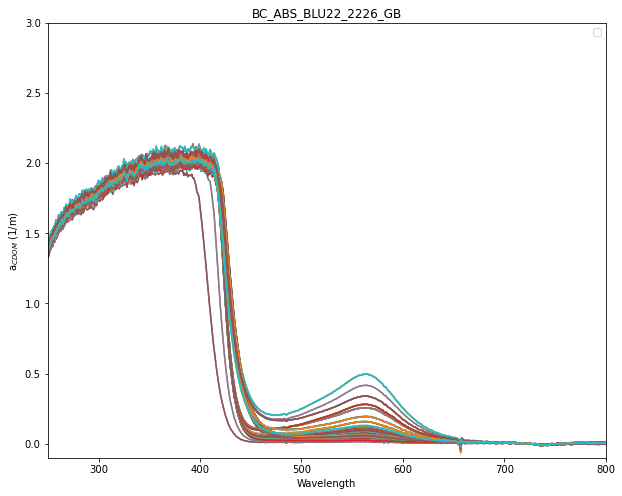

In [6]:
#HERE, WE MAKE A QUICK AND DIRTY GRAPH OF THE DATA TO SAVE AND CHECK WORK 
fig, ax = plt.subplots(figsize=(10,8))
df.plot(label='', ax=ax)
ax.set_ylim(-.1,3)
ax.set_xlim(250,800)
ax.set_xlabel("Wavelength")
ax.set_ylabel("a$_{CDOM}$ (1/m)")
ax.legend("")
ax.set_title("BC_ABS_BLU22_2226_GB")


PART 1 
THE CURVE

In [7]:
Frames = []
maxfev = 10000000
for (columnName, columnData) in df_nm.iteritems():
    col = columnName
    
    abs_562 = df_nm[(df_nm['wl']==562)][col].mean()
    
    ydata = df_nm[(df_nm['wl']>=450) & (df_nm['wl']<=700)][col]
    xdata = df_nm[(df_nm['wl']>=450) & (df_nm['wl']<=700)]['wl']
    ydata = np.asarray(ydata, dtype=float).ravel()
    xdata = np.asarray(xdata, dtype=float).ravel()
    
    inter = scipy.integrate.simps(ydata, x=xdata, even='avg')
    
    dict = {'sample':[columnName],
        'abs_562':[abs_562], 
        'intagration':[inter],}
    std_outs = pd.DataFrame(dict)
    std_outs = std_outs.set_index('sample', drop=True)
    Frames.append(std_outs)

std_outs = pd.concat(Frames, axis=0, ignore_index=False) # adds all the things in the frame together to make a new df 
std_outs = std_outs.drop('wl')
std_outs['conc'] = std_outs.index.str.rsplit('_', n=7).str[0].astype(int)
std_outs['ID'] = std_outs.index.str.rsplit('Abs', n=7).str[0]

In [8]:
#std_outs = std_outs.drop('010_nm_pre_Absorbance_12-54-26-418.txt', axis = 0)
#std_outs = std_outs.drop('020_nm_pre_Absorbance_12-57-44-229.txt', axis = 0)
#std_outs = std_outs.drop('100_nm_post_Absorbance_16-08-48-309.txt', axis = 0)
std_outs

,abs_562,intagration,conc,ID
sample,,,,
000_nm_post_Absorbance_09-17-52-531 (2).txt,0.026254,4.533901,0,000_nm_post_
000_nm_post_Absorbance_09-17-52-531.txt,0.026254,4.533901,0,000_nm_post_
000_nm_pre_Absorbance_08-07-43-223 (2).txt,0.025634,4.521851,0,000_nm_pre_
000_nm_pre_Absorbance_08-07-43-223.txt,0.025634,4.521851,0,000_nm_pre_
010_nm_post_Absorbance_09-19-53-726 (2).txt,0.055202,7.503230,10,010_nm_post_
010_nm_post_Absorbance_09-19-53-726.txt,0.055202,7.503230,10,010_nm_post_
010_nm_post_Absorbance_09-19-54-637 (2).txt,0.054972,7.451887,10,010_nm_post_
010_nm_post_Absorbance_09-19-54-637.txt,0.054972,7.451887,10,010_nm_post_
010_nm_post_Absorbance_09-19-58-283 (2).txt,0.053873,7.239598,10,010_nm_post_


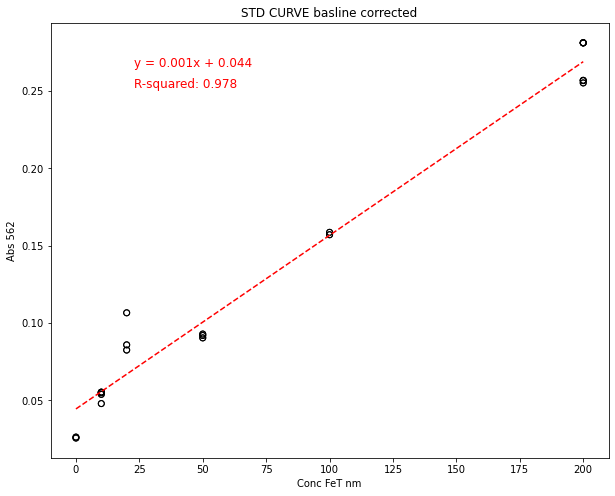

In [9]:
# create scatter plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(std_outs['conc'], std_outs['abs_562'], facecolor='none', edgecolor='black')

# add linear regression line
x = std_outs['conc']
y = std_outs['abs_562']
coefficients = np.polyfit(x, y, 1)
slope = coefficients[0]
line = np.poly1d(coefficients)
ax.plot(x, line(x), color='red', linestyle='--')

# calculate R-squared
residuals = y - line(x)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y - np.mean(y))**2)
r_squared_og1 = 1 - (ss_res / ss_tot)

# set x and y labels and title
ax.set_xlabel('Conc FeT nm')
ax.set_ylabel('Abs 562')
ax.set_title('STD CURVE basline corrected')

# print equation of line and R-squared on graph
equation = f"y = {slope:.3f}x + {coefficients[1]:.3f}"
r2_text = f"R-squared: {r_squared_og1:.3f}"
ax.text(0.15, 0.90, equation, transform=ax.transAxes, fontsize=12, color='red')
ax.text(0.15, 0.85, r2_text, transform=ax.transAxes, fontsize=12, color='red')

# show plot
plt.show()


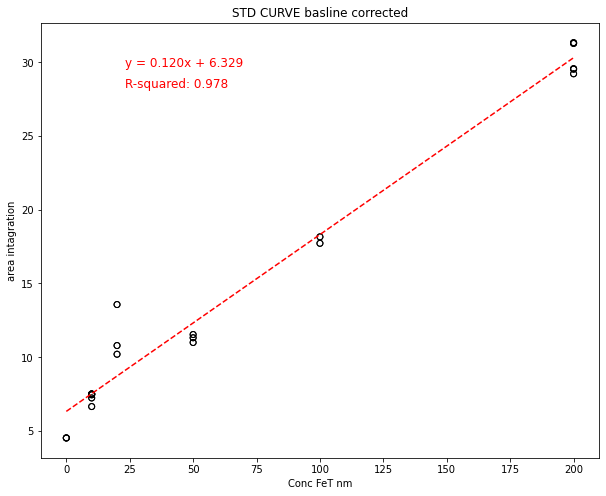

In [10]:
# create scatter plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(std_outs['conc'], std_outs['intagration'], facecolor='none', edgecolor='black')

# add linear regression line
x = std_outs['conc']
y = std_outs['intagration']
coefficients = np.polyfit(x, y, 1)
slope = coefficients[0]
line = np.poly1d(coefficients)
ax.plot(x, line(x), color='red', linestyle='--')

# calculate R-squared
residuals = y - line(x)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y - np.mean(y))**2)
r_squared_og2 = 1 - (ss_res / ss_tot)

# set x and y labels and title
ax.set_xlabel('Conc FeT nm')
ax.set_ylabel('area intagration')
ax.set_title('STD CURVE basline corrected')

# print equation of line and R-squared on graph
equation = f"y = {slope:.3f}x + {coefficients[1]:.3f}"
r2_text = f"R-squared: {r_squared_og2:.3f}"
ax.text(0.15, 0.90, equation, transform=ax.transAxes, fontsize=12, color='red')
ax.text(0.15, 0.85, r2_text, transform=ax.transAxes, fontsize=12, color='red')

# show plot
plt.show()

In [11]:
# Group by the new column 'group_name', and calculate the mean and std for each group
grouped = std_outs.groupby('ID')['abs_562'].agg(['mean', 'std'])

# Join the original dataframe with the grouped one
std_outs = std_outs.join(grouped, on='ID')
std_outs["z_score"] = np.abs(std_outs['abs_562'] - std_outs['mean']) / std_outs['std']


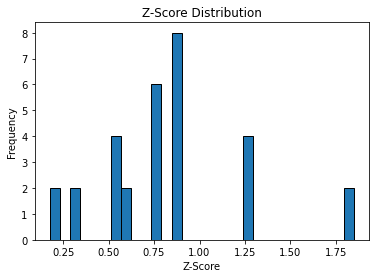

                                              abs_562  intagration  conc  \
sample                                                                     
010_nm_post_Absorbance_09-19-58-283 (2).txt  0.053873     7.239598    10   
010_nm_post_Absorbance_09-19-58-283.txt      0.053873     7.239598    10   
020_nm_pre_Absorbance_08-09-35-628 (2).txt   0.085859    10.792932    20   
020_nm_pre_Absorbance_08-09-35-628.txt       0.085859    10.792932    20   
020_nm_pre_Absorbance_08-12-50-959 (2).txt   0.082506    10.204879    20   
020_nm_pre_Absorbance_08-12-50-959.txt       0.082506    10.204879    20   
050_nm_pre_Absorbance_08-15-29-654 (2).txt   0.092844    11.539593    50   
050_nm_pre_Absorbance_08-15-29-654.txt       0.092844    11.539593    50   
050_nm_pre_Absorbance_08-15-32-391 (2).txt   0.091900    11.321382    50   
050_nm_pre_Absorbance_08-15-32-391.txt       0.091900    11.321382    50   
200_nm_post_Absorbance_09-23-36-122 (2).txt  0.255158    29.220111   200   
200_nm_post_

In [12]:
# Create a mask for rows that are 2 standard deviations away from the mean
mean_z = std_outs['z_score'].mean()
mask = np.abs(std_outs['z_score']) >  mean_z

plt.hist(std_outs['z_score'], bins=30, edgecolor='k')
plt.title('Z-Score Distribution')
plt.xlabel('Z-Score')
plt.ylabel('Frequency')
plt.show()

# Print the rows that meet the condition
print(std_outs[mask])

In [13]:
# Group by some column, calculate mean and filter groups where max z_score > mean_z
grouped = std_outs.groupby('ID').filter(lambda x: x['z_score'].max() > mean_z)

# For each group, find the row with the maximum z_score
max_z_scores = grouped.loc[grouped.groupby('ID')['z_score'].idxmax()]

# Print the rows with the highest z_score, the z_score, and other z_scores in the group
for group, data in max_z_scores.groupby('ID'):
    print(f"Group: {group}")
    print(f"Row with highest z_score: \n{data}\n")

# Remove those rows from sub_outs
std_outs = std_outs.drop(max_z_scores.index)

Group: 010_nm_post_
Row with highest z_score: 
                                              abs_562  intagration  conc  \
sample                                                                     
010_nm_post_Absorbance_09-19-58-283 (2).txt  0.053873     7.239598    10   

                                                       ID      mean       std  \
sample                                                                          
010_nm_post_Absorbance_09-19-58-283 (2).txt  010_nm_post_  0.054876  0.000542   

                                              z_score  
sample                                                 
010_nm_post_Absorbance_09-19-58-283 (2).txt  1.850338  

Group: 020_nm_pre_
Row with highest z_score: 
                                             abs_562  intagration  conc  \
sample                                                                    
020_nm_pre_Absorbance_08-12-50-959 (2).txt  0.082506    10.204879    20   

                                       

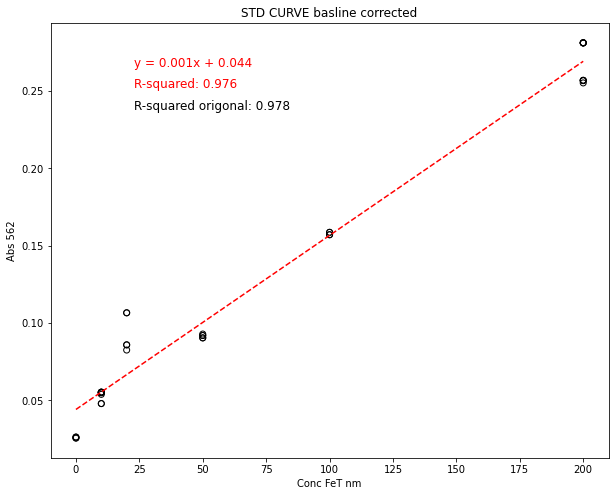

In [14]:
# create scatter plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(std_outs['conc'], std_outs['abs_562'], facecolor='none', edgecolor='black')

# add linear regression line
x = std_outs['conc']
y = std_outs['abs_562']
coefficients = np.polyfit(x, y, 1)
slope = coefficients[0]
line = np.poly1d(coefficients)
ax.plot(x, line(x), color='red', linestyle='--')

# calculate R-squared
residuals = y - line(x)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y - np.mean(y))**2)
r_squared_1 = 1 - (ss_res / ss_tot)

# set x and y labels and title
ax.set_xlabel('Conc FeT nm')
ax.set_ylabel('Abs 562')
ax.set_title('STD CURVE basline corrected')

# print equation of line and R-squared on graph
equation = f"y = {slope:.3f}x + {coefficients[1]:.3f}"
r2_text = f"R-squared: {r_squared_1:.3f}"
r2_text2 = f"R-squared origonal: {r_squared_og1:.3f}"
ax.text(0.15, 0.90, equation, transform=ax.transAxes, fontsize=12, color='red')
ax.text(0.15, 0.85, r2_text, transform=ax.transAxes, fontsize=12, color='red')
ax.text(0.15, 0.80, r2_text2, transform=ax.transAxes, fontsize=12, color='black')


# show plot
plt.show()


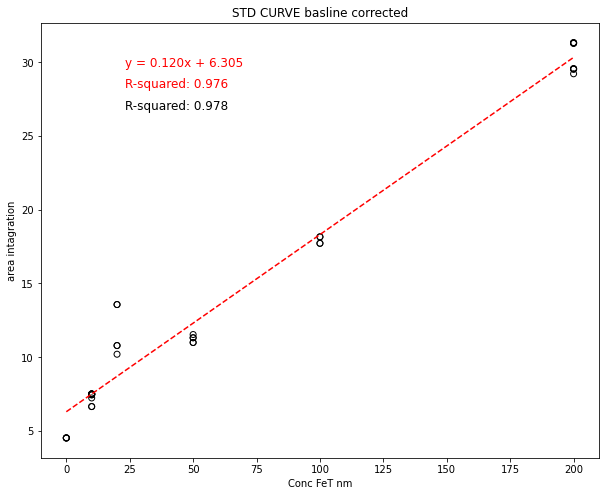

In [15]:
# create scatter plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(std_outs['conc'], std_outs['intagration'], facecolor='none', edgecolor='black')

# add linear regression line
x = std_outs['conc']
y = std_outs['intagration']
coefficients = np.polyfit(x, y, 1)
slope = coefficients[0]
line = np.poly1d(coefficients)
ax.plot(x, line(x), color='red', linestyle='--')

# calculate R-squared
residuals = y - line(x)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y - np.mean(y))**2)
r_squared_2 = 1 - (ss_res / ss_tot)

# set x and y labels and title
ax.set_xlabel('Conc FeT nm')
ax.set_ylabel('area intagration')
ax.set_title('STD CURVE basline corrected')

# print equation of line and R-squared on graph
equation = f"y = {slope:.3f}x + {coefficients[1]:.3f}"
r2_text = f"R-squared: {r_squared_2:.3f}"
r2_text2 = f"R-squared: {r_squared_og2:.3f}"
ax.text(0.15, 0.90, equation, transform=ax.transAxes, fontsize=12, color='red')
ax.text(0.15, 0.85, r2_text, transform=ax.transAxes, fontsize=12, color='red')
ax.text(0.15, 0.80, r2_text2, transform=ax.transAxes, fontsize=12, color='black')


# show plot
plt.show()

In [16]:
# Set 'conc' as the index of the DataFrame
std_outs.set_index('conc', inplace=True)

# Group by index, calculate the mean of all the columns for each group and convert it to a new DataFrame
std_outs_mean = std_outs.groupby(std_outs.index).mean()

# Now, mean_df is a new DataFrame with the mean of all the columns for each group
std_outs_mean.to_csv(path_save_1)
std_outs_mean

,abs_562,intagration,mean,std,z_score
conc,,,,,
0,0.025944,4.527876,0.025944,0.000000,NaN
10,0.053700,7.316921,0.053609,0.000444,0.616779
20,0.093475,11.787475,0.093140,0.001162,0.866025
50,0.091475,11.236156,0.091569,0.000327,0.866025
100,0.157813,17.943844,0.157813,0.000000,NaN
200,0.268740,30.396996,0.268643,0.000448,0.771330


PART 2
THE DATA

In [17]:
Frames = []
maxfev = 10000000
for (columnName, columnData) in df.iteritems():
    col = columnName
    
    abs_562 = df[(df['wl']==562)][col].mean()
    
    ydata = df[(df['wl']>=450) & (df['wl']<=700)][col]
    xdata = df[(df['wl']>=450) & (df['wl']<=700)]['wl']
    ydata = np.asarray(ydata, dtype=float).ravel()
    xdata = np.asarray(xdata, dtype=float).ravel()
    
    inter = scipy.integrate.simps(ydata, x=xdata, even='avg')
    
    dict = {'sample':[columnName],
        'abs_562':[abs_562], 
        'intagration':[inter],}
    sub_outs = pd.DataFrame(dict)
    sub_outs = sub_outs.set_index('sample', drop=True)
    Frames.append(sub_outs)

sub_outs = pd.concat(Frames, axis=0, ignore_index=False) # adds all the things in the frame together to make a new df 
mask = sub_outs.index.str.contains('nm')
sub_outs = sub_outs[~mask]
sub_outs = sub_outs.drop('wl')
sub_outs

,abs_562,intagration
sample,,
221931_Absorbance_08-31-41-626 (2).txt,0.049444,8.316396
221931_Absorbance_08-31-41-626.txt,0.049444,8.316396
221932_Absorbance_08-32-28-127 (2).txt,0.416052,48.364271
221932_Absorbance_08-32-28-127.txt,0.416052,48.364271
221933_Absorbance_08-33-29-198 (2).txt,0.040378,7.841267
...,...,...
MS222038_Absorbance_08-53-18-384.txt,0.339002,41.188532
MS222137_Absorbance_09-05-06-730 (2).txt,0.122535,16.682720
MS222137_Absorbance_09-05-06-730.txt,0.122535,16.682720


In [18]:
# Create a new column 'group_name' that contains the name you're grouping by
sub_outs['group_name'] = sub_outs.index.str.rsplit('_', n=7).str[0]

# Group by the new column 'group_name', and calculate the mean and std for each group
grouped = sub_outs.groupby('group_name')['abs_562'].agg(['mean', 'std'])

# Join the original dataframe with the grouped one
sub_outs = sub_outs.join(grouped, on='group_name')
sub_outs["z_score"] = np.abs(sub_outs['abs_562'] - sub_outs['mean']) / sub_outs['std']

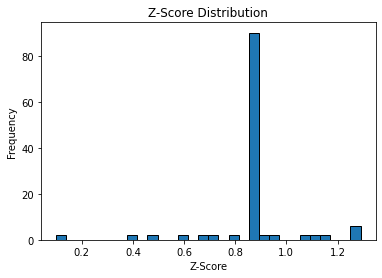

                                           abs_562  intagration group_name  \
sample                                                                       
221935_Absorbance_08-35-12-214 (2).txt    0.037675     7.226038     221935   
221935_Absorbance_08-35-12-214.txt        0.037675     7.226038     221935   
221935_Absorbance_08-35-13-125 (2).txt    0.037586     7.180633     221935   
221935_Absorbance_08-35-13-125.txt        0.037586     7.180633     221935   
221937_Absorbance_08-36-58-008 (2).txt    0.086830    12.815547     221937   
...                                            ...          ...        ...   
MS221938_Absorbance_08-40-16-756.txt      0.195173    24.905637   MS221938   
MS222038_Absorbance_08-53-17-474 (2).txt  0.339085    41.209126   MS222038   
MS222038_Absorbance_08-53-17-474.txt      0.339085    41.209126   MS222038   
MS222038_Absorbance_08-53-18-384 (2).txt  0.339002    41.188532   MS222038   
MS222038_Absorbance_08-53-18-384.txt      0.339002    41.188532 

In [19]:
# Create a mask for rows that are 2 standard deviations away from the mean
mean_z = sub_outs['z_score'].mean()
mask = np.abs(sub_outs['z_score']) >  mean_z

plt.hist(sub_outs['z_score'], bins=30, edgecolor='k')
plt.title('Z-Score Distribution')
plt.xlabel('Z-Score')
plt.ylabel('Frequency')
plt.show()

# Print the rows that meet the condition
sub_outs[mask]
print(sub_outs[mask])

In [20]:
# Group by some column, calculate mean and filter groups where max z_score > mean_z
grouped = sub_outs.groupby('group_name').filter(lambda x: x['z_score'].max() > mean_z)

# For each group, find the row with the maximum z_score
max_z_scores = grouped.loc[grouped.groupby('group_name')['z_score'].idxmax()]

# Print the rows with the highest z_score, the z_score, and other z_scores in the group
for group, data in max_z_scores.groupby('group_name'):
    print(f"Group: {group}")
    print(f"Index of row with highest z_score: \n{data.index}\n")
    print(f"Other z_scores in group: \n{grouped.loc[grouped['group_name'] == group, 'z_score']}\n")

# Remove those rows from sub_outs
sub_outs = sub_outs.drop(max_z_scores.index)

Group: 221935
Index of row with highest z_score: 
Index(['221935_Absorbance_08-35-12-214 (2).txt'], dtype='object', name='sample')

Other z_scores in group: 
sample
221935_Absorbance_08-35-12-214 (2).txt    0.866025
221935_Absorbance_08-35-12-214.txt        0.866025
221935_Absorbance_08-35-13-125 (2).txt    0.866025
221935_Absorbance_08-35-13-125.txt        0.866025
Name: z_score, dtype: float64

Group: 221937
Index of row with highest z_score: 
Index(['221937_Absorbance_08-36-58-008 (2).txt'], dtype='object', name='sample')

Other z_scores in group: 
sample
221937_Absorbance_08-36-58-008 (2).txt    0.866025
221937_Absorbance_08-36-58-008.txt        0.866025
221937_Absorbance_08-37-03-483 (2).txt    0.866025
221937_Absorbance_08-37-03-483.txt        0.866025
Name: z_score, dtype: float64

Group: 221938
Index of row with highest z_score: 
Index(['221938_Absorbance_08-38-48-352 (2).txt'], dtype='object', name='sample')

Other z_scores in group: 
sample
221938_Absorbance_08-37-45-436 (2).

In [21]:
# Set 'conc' as the index of the DataFrame
sub_outs.set_index('group_name', inplace=True)

# Group by index, calculate the mean of all the columns for each group and convert it to a new DataFrame
sub_outs_mean = sub_outs.groupby(sub_outs.index).mean()

# Now, mean_df is a new DataFrame with the mean of all the columns for each group
sub_outs_mean.to_csv(path_save_2)
sub_outs_mean

,abs_562,intagration,mean,std,z_score
group_name,,,,,
221931,0.049444,8.316396,0.049444,0.000000,NaN
221932,0.416052,48.364271,0.416052,0.000000,NaN
221933,0.040378,7.841267,0.040378,0.000000,NaN
221934,0.037196,7.488388,0.037196,0.000000,NaN
221935,0.037615,7.195768,0.037630,0.000051,0.866025
221936,0.042547,7.991518,0.042547,0.000000,NaN
221937,0.086452,12.727859,0.086546,0.000327,0.866025
221938,0.050791,9.711555,0.050601,0.000742,0.767957
222031,0.048633,9.029264,0.048633,0.000000,NaN
